# **CNN + Stacking Classifier for Skin Cancer Detection**

## **Model Description:**
This project demonstrates the use of a Convolutional Neural Network (CNN) for classifying skin cancer images into multiple classes. The model is further enhanced by applying **Principal Component Analysis (PCA)** and a **Stacking Classifier**. The stacking classifier is built using **K-Nearest Neighbors (KNN)**, **Random Forest (RF)**, and **XGBoost (XGB)** classifiers. The aim is to improve the accuracy of the base CNN model by leveraging ensemble learning techniques.

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model


## **1. Data Augmentation and Preparation**

This section applies image augmentation techniques, such as rotation, shifts, and zooming, to artificially expand the training dataset, improving the model's generalization capabilities.

In [28]:
# Set image size and batch size
img_height, img_width = 224, 224
batch_size = 64

# Augment the training data
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Only rescale the test data
test_data_gen = ImageDataGenerator(rescale=1./255)

# Load the training data (using 'categorical' for multi-class)
train_generator = train_data_gen.flow_from_directory(
    'data/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical' 
)

# Load the test data
test_generator = test_data_gen.flow_from_directory(
    'data/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical' 
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


## 2. Building the CNN Model with Regularization and Batch Normalization
 
A CNN is constructed with multiple convolutional layers. To avoid overfitting, **L1** and **L2 regularization** are applied, along with **Batch Normalization** for faster convergence and stable learning.

In [29]:
# Build the CNN model with L1 and L2 regularization and Batch Normalization
cnn_model = Sequential()

# Add convolutional layers with L2 regularization and Batch Normalization
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(1024, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and add Dense layers with L1 regularization
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

# Output layer (multi-class classification)
cnn_model.add(Dense(9, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\poorn\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 3. Training with Early Stopping and Learning Rate Scheduler

Training the model using **EarlyStopping** to avoid overfitting and **Learning Rate Scheduler** to adjust the learning rate dynamically based on validation accuracy.

In [30]:
# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

# Define the EarlyStopping callback to monitor val_accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1, mode='max')

# Load the saved model
cnn_model = load_model('cnn_skin_cancer_model.keras')

# Train the model with the EarlyStopping callback
# Train the model with EarlyStopping and Learning Rate Scheduler
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping, lr_scheduler]
)


C:\Users\poorn\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.5578 - loss: 7.4315 - val_accuracy: 0.4062 - val_loss: 8.2667 - learning_rate: 1.0000e-05
Epoch 2/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 2:19 4s/step - accuracy: 0.6406 - loss: 7.0668

C:\Users\poorn\miniconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6406 - loss: 7.0668 - val_accuracy: 0.3704 - val_loss: 8.3456 - learning_rate: 1.0000e-05
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.5442 - loss: 7.3240 - learning_rate: 1.0000e-05
Epoch 4/50


C:\Users\poorn\miniconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\poorn\miniconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.4844 - loss: 7.5046 - val_accuracy: 0.3906 - val_loss: 8.2912 - learning_rate: 1.0000e-05
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.5547 - loss: 7.2224 - val_accuracy: 0.3704 - val_loss: 7.9839 - learning_rate: 1.0000e-05
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5000 - loss: 7.5371 - learning_rate: 1.0000e-05
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.5523 - loss: 7.1123 - val_accuracy: 0.2969 - val_loss: 8.5256 - learning_rate: 1.0000e-05
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5156 - loss: 7.2873 - val_accuracy: 0.5000 - val_loss: 7.3975 - learning_rate: 1.0000e-05
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.5561 - loss: 7.1070 - learning_rate: 1.0000e-05
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7031 - loss: 6.7041 - val_accuracy: 0.4219 - val_loss: 7.8780 - learning_rate: 1.0000e-05
Epoch 11/5

In [31]:
# Evaluate the CNN model on the test data
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_generator)
print(f'CNN-only Test accuracy: {cnn_test_acc * 100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4109 - loss: 7.9375
CNN-only Test accuracy: 38.98%


#### 4. Plotting Training and Validation Accuracy and Loss

This section visualizes the training and validation accuracy and loss over the number of epochs. By plotting these, we can observe how well the model is learning and whether it's overfitting or underfitting.

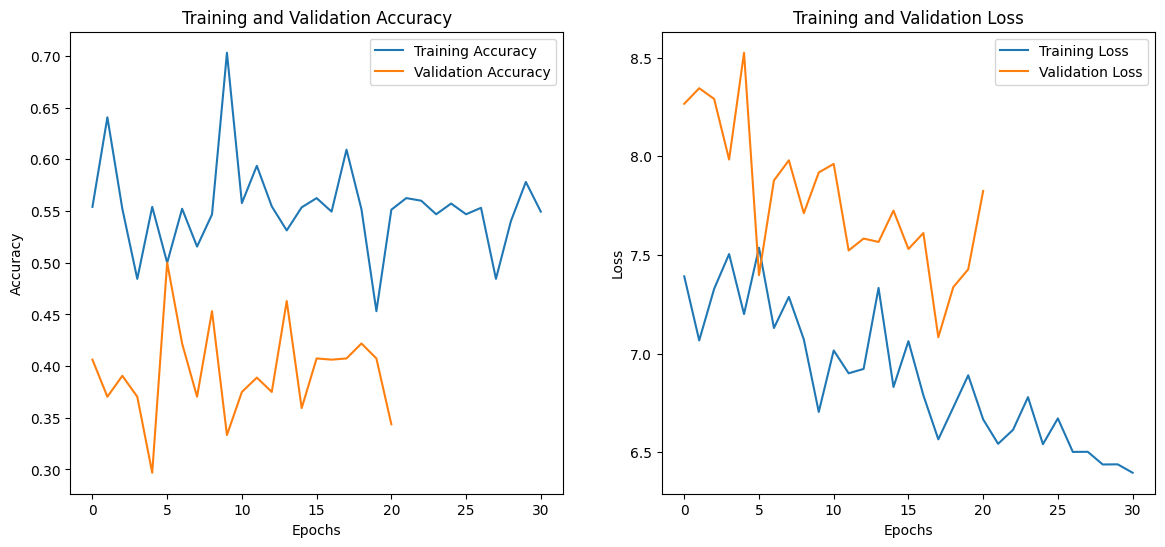

In [32]:
import matplotlib.pyplot as plt

# Create subplots to show side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the training and validation accuracy on the first subplot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot the training and validation loss on the second subplot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the figure
plt.show()

## 5. Evaluating CNN and SVM Models
 
This section evaluates the performance of both the **CNN** and **SVM** models. First, the CNN is evaluated on the test data to get its accuracy. Then, features from the CNN are used to make predictions using the **Support Vector Machine (SVM)** classifier. The SVM is fitted with an **RBF kernel** to classify the test data, and its performance is measured using a **confusion matrix** and a **classification report**.


35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
SVM Test Accuracy: 15.25%


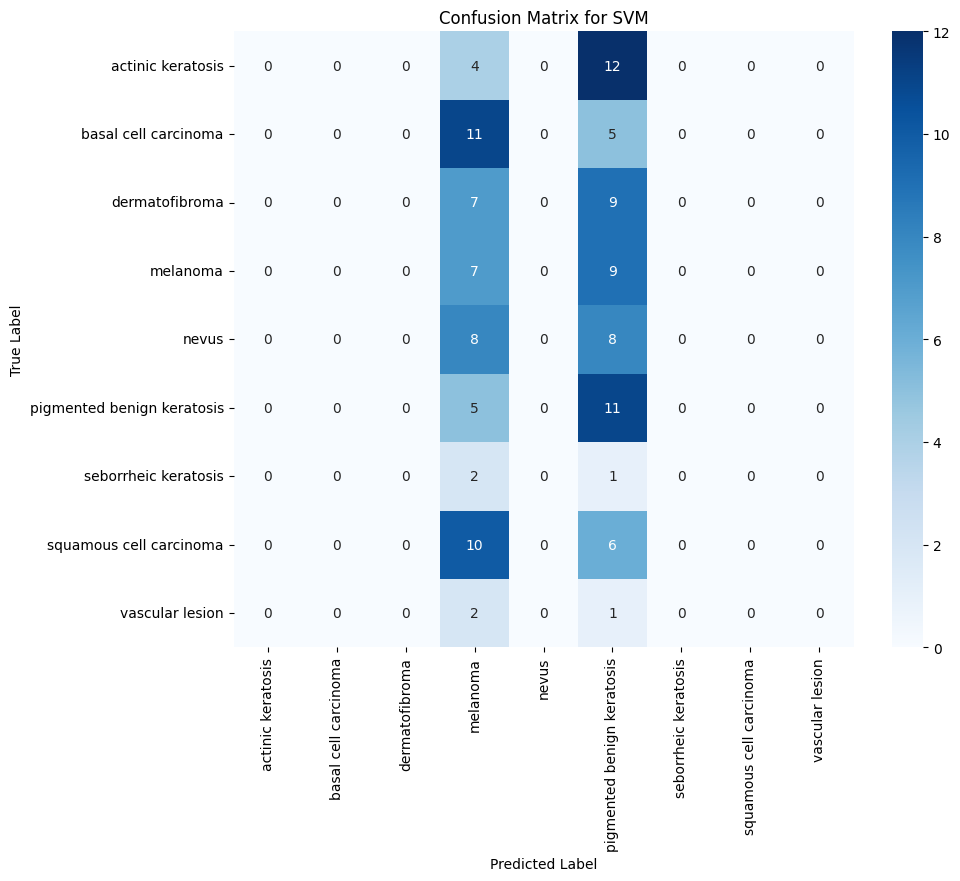

                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.00      0.00      0.00        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.12      0.44      0.19        16
                     nevus       0.00      0.00      0.00        16
pigmented benign keratosis       0.18      0.69      0.28        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.15       118
                 macro avg       0.03      0.12      0.05       118
              weighted avg       0.04      0.15      0.06       118



C:\Users\poorn\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\poorn\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\poorn\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract features from the CNN model (assuming cnn_model is already trained)
train_features = cnn_model.predict(train_generator)
test_features = cnn_model.predict(test_generator)

# Step 2: Get the labels from the generators
train_labels = train_generator.classes
test_labels = test_generator.classes

# Step 3: Scale the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Step 4: Train SVM with RBF kernel
svm_classifier = SVC(kernel='rbf', C=100, gamma=0.001)
svm_classifier.fit(train_features_scaled, train_labels)

# Step 5: Make predictions using the SVM on the test set
svm_predictions = svm_classifier.predict(test_features_scaled)

# Step 6: Calculate and print accuracy of the SVM
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print(f'SVM Test Accuracy: {svm_accuracy * 100:.2f}%')

# Step 7: Confusion Matrix
cm = confusion_matrix(test_labels, svm_predictions)

# Step 8: Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 9: Classification Report
report = classification_report(test_labels, svm_predictions, target_names=test_generator.class_indices.keys())
print(report)


## 6. Visualizing Categorized Test Images with True and Predicted Labels

This section displays a set of **test images** along with their **true labels** and **predicted labels**. The **CNN** extracts features from the images, and the **SVM classifier** is used to predict the labels. The images are displayed in two rows, showing a comparison between the true class and the class predicted by the model. This visualization helps to evaluate the classification performance at the image level.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


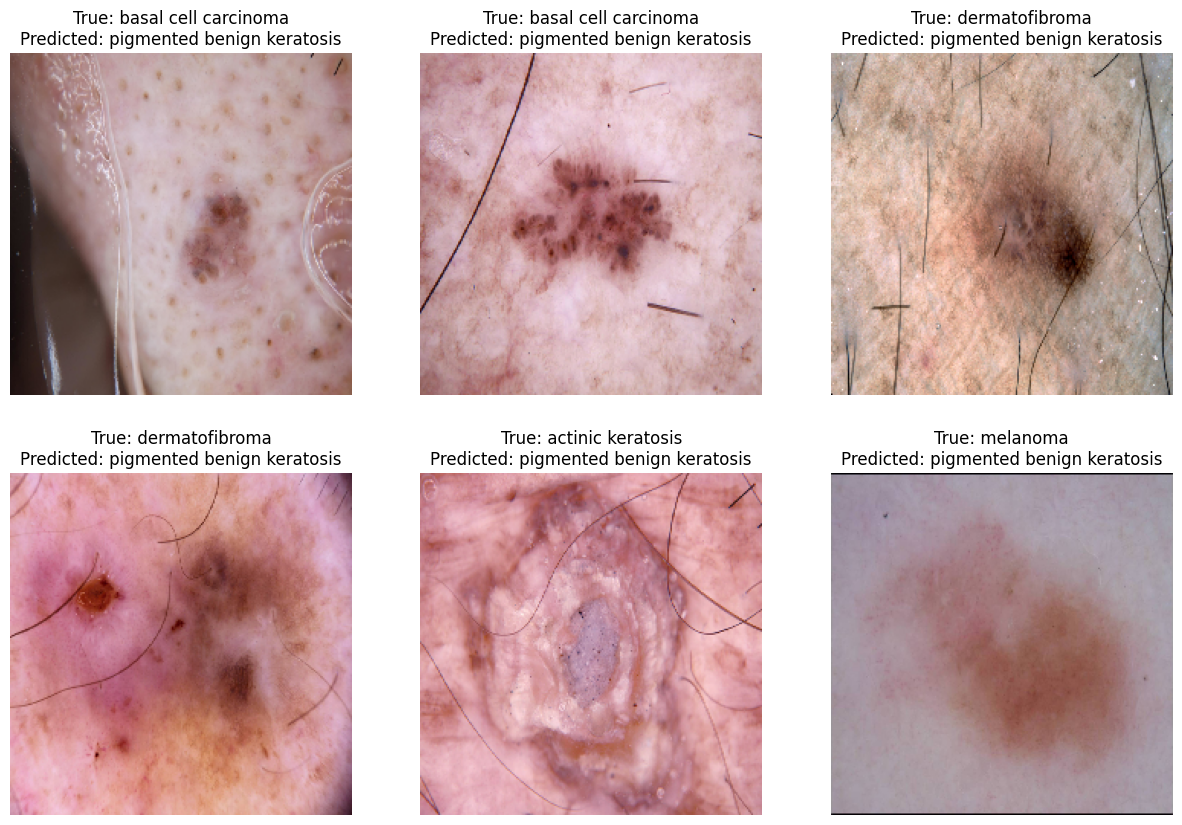

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display categorized test images
def display_test_images(generator, svm_classifier, model, num_images=6):
    # Get a batch of test images
    test_images, test_labels = next(generator)

    # Calculate how many images per row (2 rows here)
    images_per_row = num_images // 2

    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        img = test_images[i]
        label = np.argmax(test_labels[i])

        # Extract features using the CNN
        img_features = model.predict(np.expand_dims(img, axis=0))

        # Predict using SVM
        prediction = svm_classifier.predict(img_features)

        # Plot each image
        plt.subplot(2, images_per_row, i+1)  # Arrange in 2 rows
        plt.imshow(img)
        true_label = list(generator.class_indices.keys())[label]
        predicted_label = list(generator.class_indices.keys())[prediction[0]]
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
        plt.axis('off')

    plt.show()

# Call the function to display 6 categorized test images
display_test_images(test_generator, svm_classifier, cnn_model, num_images=6)

## 7. Predicting the Class of a Single Test Image

In this section, a **single test image** is loaded and preprocessed before being passed through the **CNN model** to extract features. These features are then fed into the **SVM classifier** to predict the class of the image. The predicted class label is printed to provide a clear view of the model's ability to classify individual images.

In [35]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess a single test image
img_path = 'data/Test/dermatofibroma/ISIC_0011433.jpg' 
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array /= 255.

# Extract features for the test image using the CNN
test_image_features = cnn_model.predict(img_array)

# Predict the class using the SVM classifier
svm_prediction = svm_classifier.predict(test_image_features)

# Get the class label
class_labels = list(test_generator.class_indices.keys())
predicted_class = class_labels[svm_prediction[0]]

# Output the predicted class
print(f'The predicted class is: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The predicted class is: pigmented benign keratosis


In [36]:
# Save the entire model (architecture, weights, optimizer state)
cnn_model.save('cnn_skin_cancer_model.keras')